## A quick tour of SHEEP




First some quick setup - set an environment variable so we can find our pre-made circuit files, then import the `sheep_client` module which contains methods to interact with the SHEEP API:

In [1]:
import os
if "SHEEP_HOME" in os.environ.keys():
  SHEEP_HOME = os.environ["SHEEP_HOME"]
else:
  SHEEP_HOME = os.path.join(os.environ["HOME"],"SHEEP","frontend")
import sys
sys.path.append(SHEEP_HOME)
# import the sheep_client module
from pysheep import sheep_client

Tell the SHEEP server that we want to start a new job:         

In [2]:
sheep_client.new_job()

{'content': '', 'status_code': 200}

List the available contexts:

In [3]:
sheep_client.get_available_contexts()

{'content': ['Clear',
  'HElib_F2',
  'HElib_Fp',
  'TFHE',
  'SEAL_BFV',
  'SEAL_CKKS',
  'LP',
  'PALISADE'],
 'status_code': 200}

Lets do a test with LibPaillier:

In [4]:
sheep_client.set_context("LP")

{'content': '', 'status_code': 200}

List the available input types:

In [5]:
sheep_client.get_available_input_types()

{'content': ['bool',
  'uint8_t',
  'uint16_t',
  'uint32_t',
  'int8_t',
  'int16_t',
  'int32_t',
  'double',
  'complex'],
 'status_code': 200}

Let's use uint16_t:

In [6]:
sheep_client.set_input_type("uint16_t")

{'content': '', 'status_code': 200}

Now let's give it a circuit.  There are plenty of simple circuits in the ```benchmark_inputs/``` directory.  We need to provide the full path to the circuit though so we'll use the SHEEP_HOME we defined at the start.

In [7]:
r=sheep_client.set_circuit(os.path.join(SHEEP_HOME,"benchmark_inputs/low_level/circuits/circuit-ADD-1.sheep"))

We can see the names of the "inputs" that this circuit expects:

In [8]:
sheep_client.get_inputs()

{'content': ['input_0', 'input_1'], 'status_code': 200}

Now we can set values for those inputs.  The circuit we've chosen just adds the two inputs together, so lets do 55+44 (and hope we get the answer 99 at the end!)  Note that we have to write the inputs as lists, as potentially we can do more than one calculation at the same time (known as SIMD)).

In [9]:
sheep_client.set_inputs({"input_0":[55],"input_1":[44]})

{'content': '', 'status_code': 200}

We have set the context, the input_type, the circuit_file and the input values - we should be ready to go!  Let's print out the configuration, and then check that we are fully configured.

In [10]:
sheep_client.get_config()

{'content': {'circuit_filename': '',
  'context': 'LP',
  'eval_strategy': 'serial',
  'input_type': 'uint16_t',
  'nslots': 1,
  'parameters': {'NumSlots': 1, 'n': 256}},
 'status_code': 200}

OK, let's execute the test!

In [11]:
sheep_client.run_job()

{'content': '', 'status_code': 200}

The SHEEP server just used our selected "context" (i.e. HE library) to encrypt our inputs, evaluate our circuit, and decrypt the outputs.  It also then evaluated the same circuit "in the clear" (i.e. with no encryption) so that we can check we got the right answer.   The result, including the output values, the processing times, and the clear-text check, are available as a json object.

In [12]:
r=sheep_client.get_results()
from pprint import pprint
pprint(r)

{'content': {'cleartext check': {'is_correct': True},
             'outputs': {'output_0': ['99']},
             'timings': {'decryption': '42.400000',
                         'encryption': '776.800000',
                         'evaluation': '76.900000',
                         'output_0': '30.600000'}},
 'status_code': 200}


So we can see that 
 * we got the answer "99" (which is 55+44, the sum of our two inputs) 
 * all the output values we got (just one in this case) matched the result from the "cleartext" context.
 * from the timings (which are in microseconds), the encryption and decryption were fast, but evaluating the circuit took some time.

## Using "slots"

Many HE algorithms can operate on vectors of inputs simultaneously (SIMD operations).  This is supported in SHEEP as follows:

In [13]:
sheep_client.new_job()
sheep_client.set_context("HElib_Fp")
sheep_client.set_input_type("int8_t")
sheep_client.get_nslots()

{'content': {'nslots': 4}, 'status_code': 200}

We can now introduce a new operation, ROTATE to shift the elements of the slots around:

In [14]:
sheep_client.set_circuit_text("INPUTS in \n CONST_INPUTS shift \n OUTPUTS out \n in shift ROTATE out\n")
sheep_client.set_inputs({"in": [1,2,3,4]})
sheep_client.set_const_inputs({"shift": 1})
sheep_client.run_job()
sheep_client.get_results()

{'content': {'cleartext check': {'is_correct': True},
  'outputs': {'out': ['4,1,2,3']},
  'timings': {'decryption': '531.900000',
   'encryption': '1003.300000',
   'evaluation': '4625.800000',
   'out': '4558.200000'}},
 'status_code': 200}

We only got four slots with that set of parameters in HElib, but we can try a different set:

In [15]:
sheep_client.set_parameters({"BaseParamSet": 2})
sheep_client.get_nslots()

{'content': {'nslots': 96}, 'status_code': 200}

For those libraries that do not support SIMD operations, we still allow slots (with "nslots" as a configurable parameter), but the calculation is of course slower (by a factor nslots).

In [16]:
sheep_client.set_context("TFHE")
sheep_client.get_nslots()

{'content': {'nslots': 1}, 'status_code': 200}

In [17]:
sheep_client.set_parameters({"NumSlots": 100})
sheep_client.get_nslots()

{'content': {'nslots': 100}, 'status_code': 200}

SEAL does support SIMD, and the default parameters give us a large number of slots:

In [18]:
sheep_client.new_job()
sheep_client.set_context("SEAL_BFV")
sheep_client.set_input_type("int8_t")
sheep_client.get_nslots()

{'content': {'nslots': 2048}, 'status_code': 200}

If we don't need all those slots. If we specify fewer, the server will fill the rest up with a repeating pattern of the specified inputs, so that ROTATE operations will still be correct.

Now lets try a simple "MULTIPLY" across five slots.

In [ ]:
sheep_client.set_circuit(os.path.join(SHEEP_HOME,"benchmark_inputs/low_level/circuits/circuit-MULTIPLY-1.sheep"))
sheep_client.set_inputs({"input_0":[1,2,3,4,5],"input_1":[2,4,6,8,10]})
sheep_client.run_job()
sheep_client.get_results()

## Low-level benchmarks

The first set of benchmarks to be run corresponds to circuits composed of only one type of gate, with various "depths" (i.e. numbers of nested gates).
For example, circuit-ADD-3.sheep contains three nested "ADD" gates: output=((a+b)+c)+d.

We perform several "scans" of parameter space. For each scan, some functions in benchmark_utils will be run to configure and run the HE libraries, and then we visualize the results.

We will show a shortened versoin of the first of these scans here as an example:

In [19]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pysheep.low_level_benchmarks import params_for_level, run_circuit

### Scan 1
Set parameters for the "leveled" libraries (HElib_Fp, SEAL_BFV and PALISADE) to be able to support multiplicative depth of 10, then compare the timings for different depths of ADD and MULTIPLY.

In [20]:
CIRCUIT_FILE_DIR = os.path.join(os.environ["SHEEP_HOME"],"benchmark_inputs","low_level","circuits")
## give a unique scan_id so that we can retrieve the results later on
import uuid

scan_id = str(uuid.uuid4())
## look at bool inputs
input_type = "bool"
## start looping over gates, depths, and contexts
for gate in ["ADD","MULTIPLY"]:
    for context in ["HElib_Fp","SEAL_BFV","PALISADE"]:
        params = params_for_level(context,4)
        for d in range(1,6):
            circuit_file = CIRCUIT_FILE_DIR+"/circuit-"+gate+"-"+str(d)+".sheep"
            print("Doing benchmark for %s %s %s %i" %
                            (context,gate,input_type,d))
            uploaded_OK = run_circuit(circuit_file,
                                      input_type,
                                      context,
                                      params,
                                      "serial",
                                      scan_id,
                                      timeout=60)
            if not uploaded_OK:
                print("Problem running test or uploading result")
if uploaded_OK:
    print("Finished OK")

Doing benchmark for HElib_Fp ADD bool 1
Doing benchmark for HElib_Fp ADD bool 2
Doing benchmark for HElib_Fp ADD bool 3
Doing benchmark for HElib_Fp ADD bool 4
Doing benchmark for HElib_Fp ADD bool 5
Doing benchmark for SEAL_BFV ADD bool 1
Doing benchmark for SEAL_BFV ADD bool 2
Doing benchmark for SEAL_BFV ADD bool 3
Doing benchmark for SEAL_BFV ADD bool 4
Doing benchmark for SEAL_BFV ADD bool 5
Doing benchmark for PALISADE ADD bool 1
Doing benchmark for PALISADE ADD bool 2
Doing benchmark for PALISADE ADD bool 3
Doing benchmark for PALISADE ADD bool 4
Doing benchmark for PALISADE ADD bool 5
Doing benchmark for HElib_Fp MULTIPLY bool 1
Doing benchmark for HElib_Fp MULTIPLY bool 2
Doing benchmark for HElib_Fp MULTIPLY bool 3
Doing benchmark for HElib_Fp MULTIPLY bool 4
Doing benchmark for HElib_Fp MULTIPLY bool 5
Doing benchmark for SEAL_BFV MULTIPLY bool 1
Doing benchmark for SEAL_BFV MULTIPLY bool 2
Doing benchmark for SEAL_BFV MULTIPLY bool 3
Doing benchmark for SEAL_BFV MULTIPLY bo

### Tabulating and plotting the results

We use matplotlib and pandas to plot the results, and store the results in an sqlite file:

In [26]:
from pysheep.database import BenchmarkMeasurement, session
from pysheep.benchmark_utils import levels_for_params
from pysheep.low_level_benchmarks import get_gate_name_from_circuit_name


In [27]:
def get_levels_for_row(benchmark_measurement):
    ## do the reverse lookup of params_for_level
    context = benchmark_measurement.context
    param_dict = {}
    for param in benchmark_measurement.parameters:
        param_dict[param.param_name] = param.param_value
    return levels_for_params(benchmark_measurement.context,param_dict)

def get_depth_for_row(benchmark_measurement):
    ## parse the circuit filename and see how many nested gates there were 
    return re.search("-([\d]+).sheep",benchmark_measurement.circuit_name).groups()[0]


def get_execution_time_for_row(benchmark_measurement):
    for timing in benchmark_measurement.timings:
        if timing.timing_name == "evaluation":
            return timing.timing_value

def fill_row(benchmark_measurement, columns):
    columns["context"].append(benchmark_measurement.context)
    columns["gate"].append(get_gate_name_from_circuit_name(benchmark_measurement.circuit_name))
    columns["input_bitwidth"].append(benchmark_measurement.input_bitwidth)
    columns["input_signed"].append(benchmark_measurement.input_signed)
    if "level" in columns.keys():
        columns["level"].append(get_levels_for_row(benchmark_measurement))
    if "depth" in columns.keys():
        columns["depth"].append(get_depth_for_row(benchmark_measurement))
    columns["execution_time"].append(get_execution_time_for_row(benchmark_measurement))
    return columns

In [28]:
rows_scan1 = session.query(BenchmarkMeasurement).filter_by(scan_id=scan_id).all()
dict_scan1 = {"context":[],"gate":[],"input_bitwidth":[],"input_signed":[],"depth":[], "execution_time":[]}
for row in rows_scan1:
    dict_scan1 = fill_row(row,dict_scan1)
df_scan1 = pd.DataFrame(dict_scan1)
df_scan1.head()

,context,depth,execution_time,gate,input_bitwidth,input_signed
0,HElib_Fp,1,168.3,ADD,1,False
1,HElib_Fp,2,307.6,ADD,1,False
2,HElib_Fp,3,418.9,ADD,1,False
3,HElib_Fp,4,556.7,ADD,1,False
4,HElib_Fp,5,676.8,ADD,1,False


Now lets write a function to plot execution time vs depth for each gate type:

In [29]:
def execution_time_vs_x_cat(input_dataframe, gate_name, bitwidth, is_signed, libs_list, x_var="context",category_var=None):
    ## plot execution time for different contexts vs category var (e.g. "depth", "levels")
    rows = input_dataframe[(input_dataframe.input_bitwidth==bitwidth) & 
                           (input_dataframe.gate==gate_name) & 
                           input_dataframe.context.isin(libs_list) & 
                           (input_dataframe.input_signed==is_signed)
                          ]
 #   return rows
    if category_var:
        return rows.drop_duplicates([x_var, category_var]).pivot(
            index=x_var, columns=category_var, values='execution_time')
    else:
        return rows.drop_duplicates([x_var]).pivot(
            index=x_var, values='execution_time')

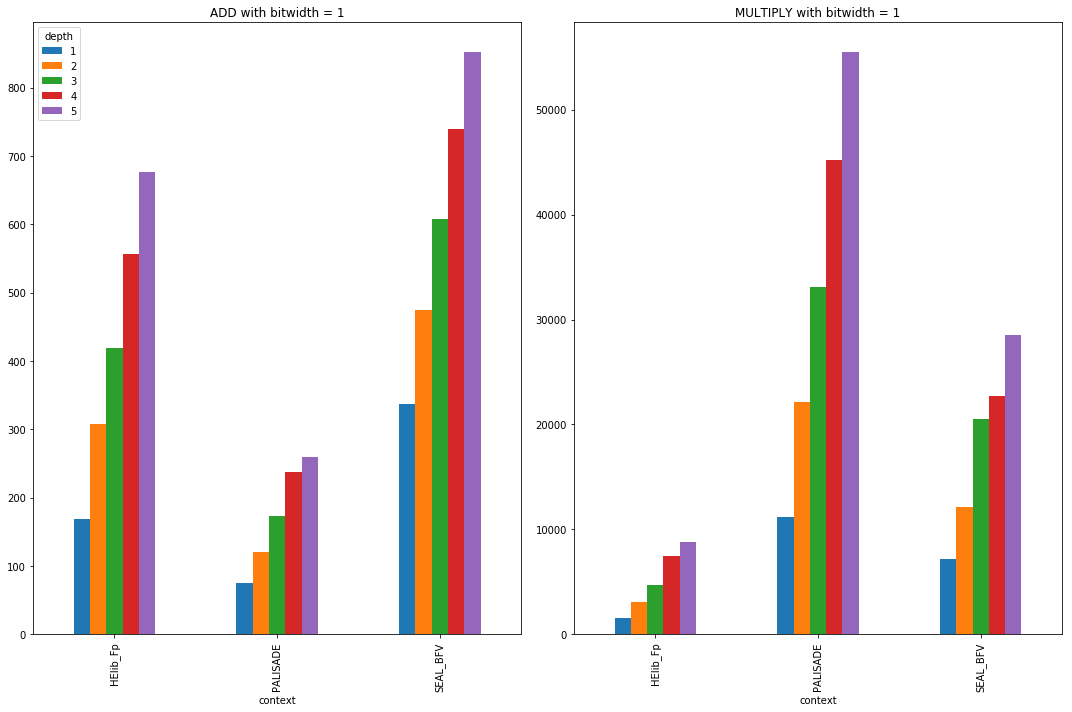

In [30]:
all_ops = set(df_scan1.gate)
bitwidth = 1
is_signed = False
for i, op in enumerate(all_ops):
    libs = ["HElib_Fp", "SEAL_BFV","PALISADE"]
    plot_scan1 = execution_time_vs_x_cat(df_scan1, op, bitwidth, is_signed, libs,"context","depth")
    axis = plt.subplot((len(all_ops) + 2 // 2) // 2, 2, i + 1)
#     axis.set_yscale("log")
    plot_scan1.plot(ax=axis, title=op + ' with bitwidth = ' + str(bitwidth), kind='bar', figsize=(15, 10), legend=False if i!=0 else True)
plt.tight_layout()
plt.show()

## Mid-level benchmark - Private Information Retrieval

One application of HE is to retrieve a data point from a database held elsewhere, without the database holder knowing which point is being requested. If Alice wants to query Bob's database, she simply encrypts an array full of zeros, except for a "1" in the position of the desired data point, and sends this ciphertext to Bob. He then performs homomorphic multiplication and addition, and sends the ciphertext back to Alice, who decrypts it to retrieve the data point she requested.

To demonstrate this on a very small scale, lets look at a "database" containing only two values: 123 and 456:

In [31]:
from pysheep.mid_level_benchmarks import generate_pir_circuit, \
    generate_variance_circuit, generate_bitonic_sort_circuit, generate_gaussian_inputs
from pysheep import benchmark_utils
from pysheep import common_utils

sheep_client.new_job() 
sheep_client.set_context("HElib_Fp")
sheep_client.set_input_type("int16_t")

{'content': '', 'status_code': 200}

Now let's generate the circuit file for this simple PIR case with two values in the "database":

In [32]:
circuit_file=generate_pir_circuit(2,[2])
sheep_client.set_circuit(circuit_file)
sheep_client.get_inputs()

{'content': ['d_0_0_0', 'd_0_1_0', 's_0_0', 's_0_1'], 'status_code': 200}

"d_a_b_c" are the "database" values, and "s_x_y" are the "selector" values. We can set d_0_0_0 and d_0_1_0 to "123" and "456" respectively. Then, to select d_0_0_0 (which will hopefully be the value "123") from the database, we should set s_0_0 to 1 and s_0_1 to zero.

In [33]:
sheep_client.set_inputs({"d_0_0_0": [123], "d_0_1_0": [456], "s_0_0": [1], "s_0_1": [0]})
sheep_client.run_job()

{'content': '', 'status_code': 200}

In [34]:
sheep_client.get_results()

{'content': {'cleartext check': {'is_correct': True},
  'outputs': {'e_0_0': ['123']},
  'timings': {'c_0_0_0': '1451.900000',
   'c_0_1_0': '1297.500000',
   'decryption': '331.000000',
   'e_0_0': '73.000000',
   'encryption': '3815.700000',
   'evaluation': '3040.800000'}},
 'status_code': 200}

So we successfully got the output value "123", i.e. the first entry in the "database".

## Mid-level benchmark - Matrix vector multiplication

Lets do the following calculation:
\begin{equation*}
\begin{vmatrix}
1, 2 , 3 , 4\\
5 , 6 , 7 , 8\\
9, 10, 11, 12 \\
13, 14 , 15, 16
\end{vmatrix}
\begin{vmatrix}
1 \\
2 \\
3 \\
4
\end{vmatrix}
\end{equation*}

which should give us the answer {30, 55, 110, 150}

### a) The straightforward (but non-optimal) way

Essentially the each element of the output vector will be the dot product of the corresponding row of the matrix with the vector.  We can therefore do this in the same way as was demonstrated in the vector_dot_product notebook, i.e. component-wise multiplication followed by a sequence of rotations and additions.

The circuit will look like:

In [35]:
circuit = """
INPUTS mrow_0 mrow_1 mrow_2 mrow_3 vec mask
CONST_INPUTS rotate_by_minus1 rotate_by_plus1 rotate_by_plus2 rotate_by_plus3
OUTPUTS output_vec 
# dot product of the first row with the vector
mrow_0 vec MULTIPLY prod_00
prod_00 rotate_by_minus1 ROTATE prod_01
prod_00 prod_01 ADD sum_00
prod_01 rotate_by_minus1 ROTATE prod_02
sum_00 prod_02 ADD sum_01
prod_02 rotate_by_minus1 ROTATE prod_03
sum_01 prod_03 ADD sum_0
# dot product of the second row with the vector
mrow_1 vec MULTIPLY prod_10
prod_10 rotate_by_minus1 ROTATE prod_11
prod_10 prod_11 ADD sum_10
prod_11 rotate_by_minus1 ROTATE prod_12
sum_10 prod_12 ADD sum_11
prod_12 rotate_by_minus1 ROTATE prod_13
sum_11 prod_13 ADD sum_1
# dot product of the third row with the vector
mrow_2 vec MULTIPLY prod_20
prod_20 rotate_by_minus1 ROTATE prod_21
prod_20 prod_21 ADD sum_20
prod_21 rotate_by_minus1 ROTATE prod_22
sum_20 prod_22 ADD sum_21
prod_22 rotate_by_minus1 ROTATE prod_23
sum_21 prod_23 ADD sum_2
# dot product of the third row with the vector
mrow_3 vec MULTIPLY prod_30
prod_30 rotate_by_minus1 ROTATE prod_31
prod_30 prod_31 ADD sum_30
prod_31 rotate_by_minus1 ROTATE prod_32
sum_30 prod_32 ADD sum_31
prod_32 rotate_by_minus1 ROTATE prod_33
sum_31 prod_33 ADD sum_3
# now we have four vectors, sum_0, sum_1, sum_2 and sum_3, where the first element is 
# the dot product of that row.  We need to isolate just this element, using mask, which is [1,0,0,0]
sum_0 mask MULTIPLY msum_0
sum_1 mask MULTIPLY msum_10
msum_10 rotate_by_plus1 ROTATE msum_1
sum_2 mask MULTIPLY msum_20
msum_20 rotate_by_plus2 ROTATE msum_2
sum_3 mask MULTIPLY msum_30
msum_30 rotate_by_plus3 ROTATE msum_3
# now we should have four vectors with one non-zero element each in the right place - need to sum them
msum_0 msum_1 ADD out_01
out_01 msum_2 ADD out_02
out_02 msum_3 ADD output_vec
"""

In [36]:
sheep_client.new_job()
sheep_client.set_context("HElib_Fp")
sheep_client.set_input_type("int16_t")
sheep_client.set_parameters({"Levels":30})
sheep_client.set_circuit_text(circuit)
sheep_client.get_inputs()

{'content': ['mrow_0', 'mrow_1', 'mrow_2', 'mrow_3', 'vec', 'mask'],
 'status_code': 200}

In [ ]:
sheep_client.get_const_inputs()

In [ ]:
sheep_client.set_inputs({"mrow_0": [1,2,3,4], "mrow_1": [5,6,7,8], "mrow_2": [9,10,11,12], "mrow_3": [13,14,15,16],"vec": [1,2,3,4], "mask": [1,0,0,0]})
sheep_client.set_const_inputs({"rotate_by_minus1": -1, "rotate_by_plus1": 1, "rotate_by_plus2": 2, "rotate_by_plus3":3})
sheep_client.run_job()
                              

In [ ]:
sheep_client.get_results()

In [ ]:
benchmark_utils.upload_results("matrix_vector_mult_4x4x4")

In [ ]:
sheep_client.new_job()
sheep_client.set_context("SEAL_BFV")
sheep_client.set_input_type("int16_t")
sheep_client.set_circuit_text(circuit)
sheep_client.set_inputs({"mrow_0": [1,2,3,4], "mrow_1": [5,6,7,8], "mrow_2": [9,10,11,12], "mrow_3": [13,14,15,16],"vec": [1,2,3,4], "mask": [1,0,0,0]})
sheep_client.set_const_inputs({"rotate_by_minus1": -1, "rotate_by_plus1": 1, "rotate_by_plus2": 2, "rotate_by_plus3":3})
sheep_client.run_job()
benchmark_utils.upload_results("matrix_vector_mult_4x4x4")

In [ ]:
rows = session.query(BenchmarkMeasurement).filter_by(circuit_name="matrix_vector_mult_4x4x4").all()
df_dict = {"Context": [], "Gate": [], "Time": []}
for row in rows:
    timingdict = benchmark_utils.timing_per_gate_type(row.timings, circuit)
    for k,v in timingdict.items():
        df_dict["Context"].append(row.context)
        df_dict["Gate"].append(k)
        df_dict["Time"].append(v)
df = pd.DataFrame(df_dict)
df

In [ ]:
pivot_df = df.pivot(index='Context', columns='Gate', values='Time')
pivot_df.plot(kind='bar',stacked=True)